# Zero-shot learning for image classification 

original data and code can be found here https://www.mpi-inf.mpg.de/departments/computer-vision-and-multimodal-computing/research/zero-shot-learning/zero-shot-learning-the-good-the-bad-and-the-ugly/)
[Akata, et al. CVPR2015]
[Xian, et al. CVPR2017]

Download prepared data of Animal with attributes from: 
https://drive.google.com/open?id=1ErU12Q2sHhB2Lb7NCQuan0K3qXP78RJj

In [1]:
import pdb
import time
import numpy as np
from livelossplot import PlotLosses

In [2]:
# load prepared data 
your_path_to_data_dict= '/home/SharedFolder/git/Nour-small-samples/notebooks/ZSL/Data/data_dict.npz' # PATH TO DATA
data_dict = np.load(your_path_to_data_dict,encoding = 'latin1')['data'].item()

tr_theta_x = data_dict['tr_theta_x'] # training image features extracted from deep CNN
tr_labels = data_dict['tr_labels'] # training image labels as indices matching class embeddings and names
val_theta_x = data_dict['val_theta_x']# validation image features extracted from deep CNN
val_labels = data_dict['val_labels'] # validation image labels as indices matching class embeddings and names
test_theta_x = data_dict['test_theta_x'] # test image features extracted from deep CNN
test_labels = data_dict['test_labels'] # test image labels as indices matching class embeddings and names

class_embeddings = data_dict['phi_y'] # class attributes vectors provided by the original dataset AWA

class_names = data_dict['class_name'] # class names in the same order as embeddings 

In [3]:
# print training, validation, and test class names
# note that class_embeddings and class_names 
len(class_names)
# add your implementation   

50

In [4]:
np.array(class_names)[list(set(tr_labels))]

array(['antelope', 'grizzly+bear', 'killer+whale', 'persian+cat',
       'german+shepherd', 'siamese+cat', 'skunk', 'tiger', 'hippopotamus',
       'spider+monkey', 'humpback+whale', 'elephant', 'fox', 'squirrel',
       'rhinoceros', 'wolf', 'chihuahua', 'weasel', 'otter', 'buffalo',
       'zebra', 'pig', 'lion', 'mouse', 'polar+bear', 'collie', 'cow'],
      dtype='<U15')

In [5]:
np.array(class_names)[list(set(val_labels))]

array(['beaver', 'dalmatian', 'giant+panda', 'deer', 'mole', 'leopard',
       'moose', 'raccoon', 'gorilla', 'ox', 'chimpanzee', 'hamster',
       'rabbit'], dtype='<U15')

In [6]:
np.array(class_names)[list(set(test_labels))]

array(['rat', 'horse', 'blue+whale', 'bobcat', 'walrus', 'dolphin',
       'sheep', 'seal', 'bat', 'giraffe'], dtype='<U15')

In [7]:
tr_theta_x.shape

(20218, 2048)

In [8]:
def l2_norm(x):
    return x / (np.linalg.norm(x) + 10e-6)

def train(X, Y, LR, num_epochs, W = None):
    
    # add your implementation
    
    ####### use SGD to minimize SJE loss ######### 
    # Initialize W (DxE)
    # foreach epoch 
        # Shuffle training samples
        # foreach sample (xi, yi)
            # 1. scoretrue =  𝛳(xi) * WT * class_embedding(yi)
            ### find the label that causes the maximum loss ### 
            # 2. lossmax= -1,  ymax = -1
            # foreach training label y_train  
                # 1. score =  𝛳(xi) * WT * class_embedding(y_train)
                # 2. loss = Δ(y_train,yi) + score - scoretrue
                # 3. if loss > lossmax --> update lossmax and ymax
            # 4. if ymax ≠ ytrue --> W = W - lr * 𝛳(xi) [class_embedding(yi) - class_embedding(ymax)]
    liveloss = PlotLosses()
    running_loss = 0
    
    W = np.ones((X.shape[1], class_embeddings.shape[1]))
    for epoch in range(num_epochs):
        randomize = np.arange(len(X))
        np.random.shuffle(randomize)
        X = X[randomize]
        Y = Y[randomize]
        for i in range(X.shape[0]):
            x_i = X[i, :]
            phi_yi = class_embeddings[Y[i]]
            
            #scoretrue = np.dot(np.dot(x_i.T, W), phi_yi)
            scoretrue = np.dot(l2_norm(np.dot(x_i.T, W)), phi_yi)
            
            lossmax = -1
            ymax = -1
            for j in np.unique(tr_labels):
                
                #score = np.dot(np.dot(x_i.T, W), class_embeddings[j, :])
                score = np.dot(l2_norm(np.dot(x_i.T, W)), class_embeddings[j, :])
                
                loss = (0 if j == Y[i] else 1) + score - scoretrue
                if loss > lossmax:
                    lossmax = loss
                    ymax = j                                                
            if ymax != Y[i]:
                helper = np.expand_dims(class_embeddings[ymax, :] - phi_yi, axis = 0)
                W -= lr * (np.expand_dims(x_i, axis = 1) @ helper)
            
            running_loss += lossmax
        liveloss.update({"loss": running_loss / X.shape[0]})
        liveloss.draw()
        running_loss = 0
        
    return W

In [9]:
def predict(x,test_class_indices,W):
    
    # add your implementation
    
    #  max_score = -1,  ymax = -1
    # foreach label in test_class_indices for i in test_class_indices: 
        # score =  𝛳(xi) * WT *𝜙(label) 
        # if score > max_score --> update max_score and ymax
    max_score = -1
    ymax = -1
    for i in test_class_indices:
        
        #score = x @ W @ class_embeddings[i]
        score = l2_norm(x @ W) @ class_embeddings[i]
        
        if score > max_score:
            max_score = score
            ymax = i
    return ymax

In [10]:
def evaluate(X,Y,test_class_indices,W):
    
    # add your implementation
    
    # correct_pred = 0
    # foreach sample (xi, ytrue)
        # pred_label = predict(xi,test_class_indices,W)
        # if pred_label == ytrue:
            # correct_pred += 1
    # acc = correct_pred / size of test set
    correct_pred = 0
    for i in range(X.shape[0]):
        pred_label = predict(X[i, :], test_class_indices, W)
        if pred_label == Y[i]:
            correct_pred += 1
    acc = correct_pred / X.shape[0]
    return acc

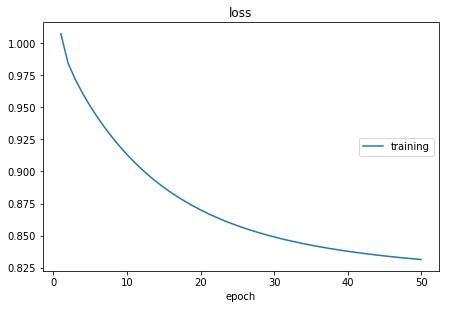

loss:
training   (min:    0.831, max:    1.007, cur:    0.831)
Trained 50 epochs in 3141.86s ... accuracy = 0.4513


In [11]:
tic = time.time()
lr = 0.1
num_epochs = 50
W = train(tr_theta_x, tr_labels, LR = lr, num_epochs = num_epochs)
print(f'Trained {num_epochs} epochs in {(time.time() - tic):.2f}s ... accuracy = {evaluate(test_theta_x, test_labels, np.unique(test_labels), W):.4f}')